In [1]:
#importin vajalikud moodulid
import pandas as pd
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

## Eeltöötlus

In [2]:
#loen sisse .csv faili
start = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data=start

#segan andmed juhuks kui need on mingis kindlas järjekorras
data = sklearn.utils.shuffle(data, random_state=42)

In [3]:
#kaotan ära kliendi ID tulba, sest et see ei mõjuta kliendi lahkumist
data=data.drop(['customerID'],axis=1)

#kaotan ära read kus pole on kogumaksumuseks märgitud ' ', sest neid ridu on ainult 8
data=data[data['TotalCharges'] != ' ']

#muudan kogumaksumuse tulba float tüübiks, kuna see võiks olla numbriliste väärtustega
#nii saab seda mudelis ühe omadusena kasutada
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [4]:
#eraldan tulba 'Churn' mida hakkame ennustama
#hetkel on seal väärtused Jah ja Ei mis teisendama numbrilisteks et neid saaks ennustada
y=data.Churn.map({'Yes':True,'No':False})

#eraldan tulbad mille põhjal hakkama tunnust 'Churn' ennustama
X=data
X=X.drop(['Churn'],axis=1)

#kõik tulbad, mis sisaldavad sõne tüüpi väärtusi, neist teeme onehot vektorid
#nii saame neid tunnuseid mudelis kasutada
for col in X.select_dtypes(include=['object']).columns:

    #loome onehot vektori tulbal
    onehot = pd.get_dummies(data[col],prefix=col+'_')

    #kaotame algse tulba ära ja lisame juurde uue onehot vektori
    X = X.drop([col], axis=1)
    X = X.join(onehot)

In [5]:
#jagame andmed laiali treening- ja testandmeteks
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#loome scaleri, et teisendada kõik tulbad samale skaalale
scaler = sklearn.preprocessing.MinMaxScaler()

#teisendame nii test- kui treeningandmed vahemikku (0,1)
X_train[X.columns] = scaler.fit_transform(X_train[X.columns])
X_test[X.columns] = scaler.transform(X_test[X.columns])

In [6]:
#kasutan SMOTE tehnikat et genereerida juurde juhte kus klient lahkuks, selleks, et oleks balanseeritud andmesik
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train,y_train)
X_test, y_test = smote.fit_resample(X_test,y_test)

## Mudelite treenimine

In [7]:
#Testime milline mudel on kõige parem ennustamiseks

# loon 5 erineva mudeliga sõnastiku, kus on omavahel seotud mudeli nimi ja mudel ise
mudelite_nimed_ja_mudelid = {'Logistic Regression':LogisticRegression(max_iter=10000,random_state=42),
                            'Decision Tree':DecisionTreeClassifier(random_state=42),
                            'Random Forest':RandomForestClassifier(random_state=42),
                            'Gaussian Naive Bayes':GaussianNB(),
                            'SVC':SVC(kernel='linear',probability=True)}

#loon tühja listi kuhu lisada iga mudeli AUC
aucd = []

#itereerin üle mudelite nimede
for nimi in mudelite_nimed_ja_mudelid.keys():

    # treenin mudeli vastavalt treeningandmetele
    mudel = mudelite_nimed_ja_mudelid[nimi]
    mudel.fit(X_train,y_train)

    #ennustan klasside tõenäosusi (0 - püsiv klient, 1-lahkuv klient)
    #võtame tulemused üle ühe kuna tahame teada klass 1 tõenäosusi
    y_pred_prob = mudel.predict_proba(X_test)[:, 1] 

    #arvutan AUC
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # lisan leitud AUC listi, kus on kõigi mudelite AUCd
    aucd.append(auc)

<Axes: title={'center': '5 valitud mudeli AUC'}, xlabel='Nimi'>

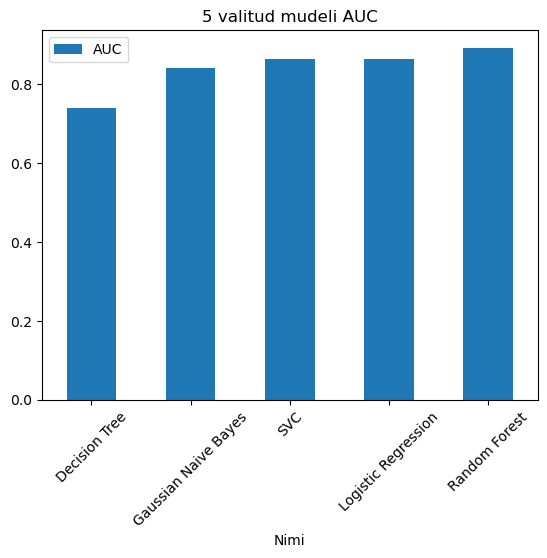

In [8]:
# loon DataFrame'i kus on tulpateks mudeli nimi ja mudeli AUC
tulemused = pd.DataFrame(
    {'Nimi': mudelite_nimed_ja_mudelid.keys(),
     'AUC': aucd
    })

#sorteerin DataFrame'i AUC järgi
tulemused = tulemused.sort_values(by='AUC')

#loon joonise AUC-de tulemuste visualiseerimiseks
tulemused.plot(x='Nimi',y=['AUC'],kind='bar',rot=45, title="5 valitud mudeli AUC")

#### Joonise järeldus
Kõige parem mudel on AUC järgi Random Forest. Kasutame seda kõige olulisemate tunnuste leidmiseks

## Oluliste tegurite leidmine

<Axes: title={'center': 'Lahkumist enim mõjutavad tegurid'}, ylabel='Omadus'>

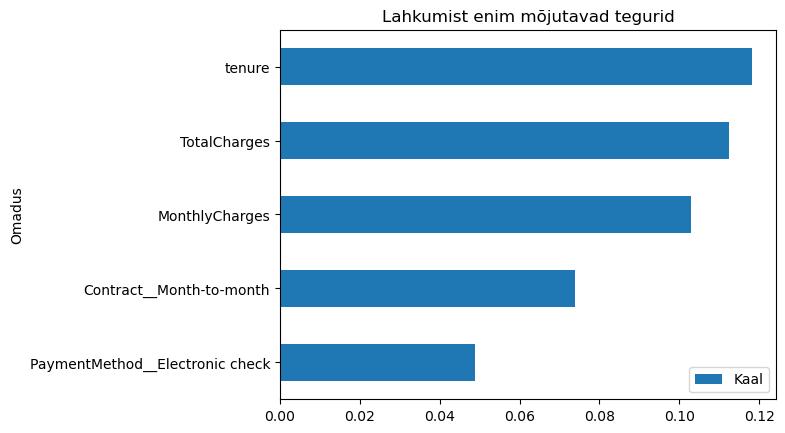

In [9]:
#treenime Random Forest mudeli
mudel = mudelite_nimed_ja_mudelid['Random Forest']
mudel.fit(X_train,y_train)

# loon DataFrame'i kus on tulpateks mudeli omadus ja tema kaal ehk tähtsus mudelis
kaalud = pd.DataFrame(
    {'Omadus': X.columns,
     'Kaal': mudel.feature_importances_
    })

# sorteerin väärtused DataFrame'is kaalu järgi kahanevalt ja võtan esimesed 10 väärtust
lahkumist_soosivad = kaalud.sort_values(by='Kaal',ascending=False)[:5][::-1]

#loon joonise visualiseerimaks mis on tähtsamad tunnused inimese lahkumisel
lahkumist_soosivad.plot(x='Omadus',y='Kaal',kind='barh',title="Lahkumist enim mõjutavad tegurid")

#### Analüüs
Joonise pealt on näha, et tegur, mis kõige rohkem mõjutab kliendi lahkumist, kliendi seni oldud aeg. Selle põhjuseks võiks olla asjaolu, et klient on andnud firmale aega ennast tõestada, kuid on nüüd valmis lahkuma, et otsida paremat pakkumist.
Tähtsad tegurid on veel iga kuu tasud ja kogumaksumus oldud aja peale. See näitab, et madalad teenuste tasud on olulised klientide hoidmisel.
Tegur, mille nägemine joonisel ei üllata, on lepingu tüüp kuust-kuusse. See tähendab, et klient kaalub iga kuu oma valikuid ning jätab alati endale võimaluse lahkuda, kuna pole kindel firma pädevuses. Nüüd otsustas ta lahkuda ning proovida uut firmat.
Tegur, millest ei tasuks liiga palju välja lugeda, on elektroonilise tšekiga makseviis, kuna makseviisist ei sõltu inimeste rahulolu firmaga.

<Axes: title={'center': 'Jäämist enim mõjutavad tegurid'}, ylabel='Omadus'>

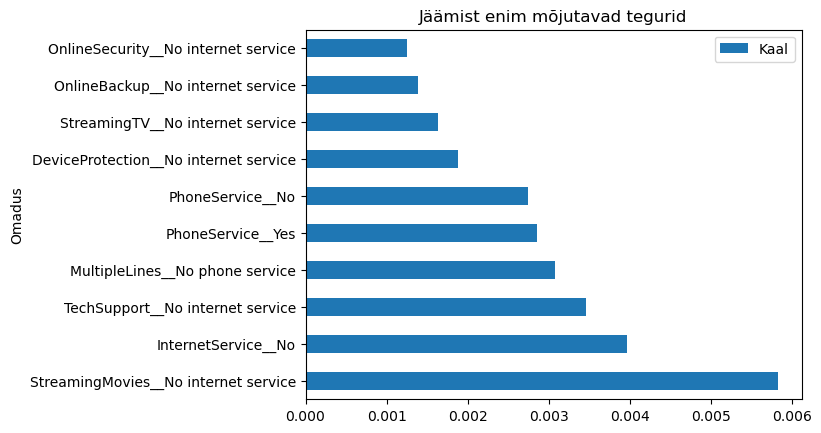

In [10]:
# sorteerin väärtused DataFrame'is kaalu järgi tõusvalt ja võtan esimesed 10 väärtust
jäämist_soosivad = kaalud.sort_values(by='Kaal')[:10][::-1]

#loon joonise visualiseerimaks mis on tähtsamad tunnused inimese jäämisel
jäämist_soosivad.plot(x='Omadus',y='Kaal',kind='barh',title="Jäämist enim mõjutavad tegurid")

#### Analüüs
Enim jäämist mõjutavad tegurid on seotud sellega, et kliendil ei ole internetiteenust. Telefoniteenust omavad kliendid aga on sama tõenäolised jääma, kui kliendid, kes ei oma telefoniteenust. Sellest võiks järeldada, et telefoniteenusega ollakse üldiselt rahul, kuid ka need, kes ei oma seda, on rahul muude teenustega. Samuti on rahul ka teiste teenustega need, kes ei oma internetiteenust. Kokkuvõttes võiks öelda, et telefoniteenusega ollakse rohkem rahul kui internetiteenusega. See on ka loogiline, sest telefoniteenuses on keeruline midagi tuksi keerata, rohkem on probleem inimestel hinnaga. Internetiteenuse puhul on lihtne kritiseerida, kui veebilehed aeglaselt ära laevad. Järelikult ollakse telefoniteenuse hinnaga rahul.